# Neural Prophet Forecasting model

## Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from snowflake.snowpark import Session

import warnings

# Ignore only DeprecationWarnings
warnings.filterwarnings('ignore')

from neuralprophet import NeuralProphet

from utils import create_session, mape
import utils

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Data Setup

In [6]:
df = utils.get_time_series_1()

df = utils.z_score_outlier(df, 2)

cutoff = round(len(df)*0.8)
train = df[:cutoff]
test = df[cutoff:]

          ds          y
0 2012-03-02  137233.99
1 2012-03-03  190247.55
2 2012-03-04  197809.12
3 2012-03-05  125417.64
4 2012-03-06  120953.92
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      364 non-null    datetime64[ns]
 1   y       364 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None
Dropping 12 rows.


## Simple Neural Prophet

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (18) is too small than the required number                     for the learning rate finder (214). The results might not be optimal.


Epoch 170: 100%|██████████| 170/170 [00:10<00:00, 15.92it/s]    

Finding best initial lr: 100%|██████████| 214/214 [00:03<00:00, 55.33it/s]


Training: |          | 0/? [00:42<?, ?it/s, v_num=48, train_loss=0.0178, reg_loss=0.000, MAE=7.25e+3, RMSE=1.08e+4, Loss=0.0175, RegLoss=0.000]


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.82it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


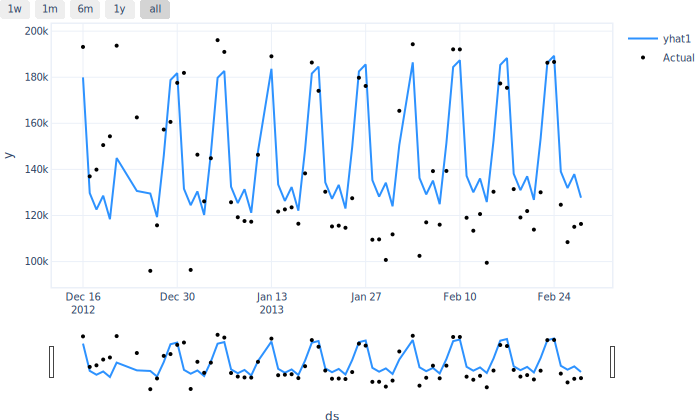

In [7]:
params = {"weekly_seasonality":True}

m = NeuralProphet(**params)

m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(train, freq='D')
forecast = m.predict(test)

m.plot(forecast)

In [8]:
nn_prophet_mape = mape(test['y'], forecast['yhat1'])
print(f'Neural Prophet MAPE: {nn_prophet_mape}%')

Neural Prophet MAPE: 10.99%


## Cross Validation

In [9]:
# setup

def cross_validation(params, df):
    folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="D", k=5, fold_pct=0.20, fold_overlap_pct=0.5)
    tests = []
    forecasts = []

    for df_train, df_test in folds:
        m = NeuralProphet(**params)
        m.set_plotting_backend("plotly-static")
        train = m.fit(df=df_train, freq="D")
        forecast = m.predict(df_test)
        test = m.test(df=df_test)
        tests.append(test)
        forecasts.append(forecast)

    return tests, forecasts#, metrics_train, metrics_test


In [10]:
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}
cv_metrics, cv_forecast = cross_validation(params, df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set ep

Training: |          | 0/? [00:27<?, ?it/s, v_num=49, train_loss=0.0184, reg_loss=0.000, MAE=6.69e+3, RMSE=1.04e+4, Loss=0.0182, RegLoss=0.000]


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.46it/s]


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.87% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.020532485097646713
         MAE_val              6870.7080078125
        RMSE_val              9399.7255859375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 220: 100%|██████████| 220/220 [00:00<00:00, 373.40it/s]   

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200



Training: |          | 0/? [00:29<?, ?it/s, v_num=50, train_loss=0.0162, reg_loss=0.000, MAE=6.54e+3, RMSE=9.63e+3, Loss=0.0162, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.10it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.94it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.057% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.020649800077080727
         MAE_val             6852.09814453125
        RMSE_val              9319.6123046875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training: |          | 0/? [00:39<?, ?it/s, v_num=51, train_loss=0.0169, reg_loss=0.000, MAE=6.62e+3, RMSE=9.9e+3, Loss=0.0168, RegLoss=0.000] 


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.83it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.19% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 180



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test            0.045970618724823
         MAE_val              9803.9619140625
        RMSE_val                14738.1875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training: |          | 0/? [00:46<?, ?it/s, v_num=52, train_loss=0.0142, reg_loss=0.000, MAE=6.22e+3, RMSE=9.32e+3, Loss=0.014, RegLoss=0.000] 


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.03it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.48it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06969165802001953
         MAE_val             12451.9033203125
        RMSE_val               19221.1484375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 180: 100%|██████████| 180/180 [00:00<00:00, 411.93it/s]   

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170



Training: |          | 0/? [00:40<?, ?it/s, v_num=53, train_loss=0.0169, reg_loss=0.000, MAE=6.98e+3, RMSE=1.03e+4, Loss=0.0169, RegLoss=0.000]


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.79it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0584387369453907
         MAE_val              13547.337890625
        RMSE_val                17830.9375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [11]:
combined_forecast = pd.concat(cv_forecast)
print(combined_forecast)
print(f"MAPE: {mape(combined_forecast['y'], combined_forecast['yhat1'])}%")

           ds          y          yhat1          trend  season_weekly
0  2012-07-24  110804.26  110167.625000  126954.343750  -16786.718750
1  2012-07-25  107367.45  114739.523438  126983.671875  -12244.150391
2  2012-07-26  103476.04  106658.437500  127013.007812  -20354.570312
3  2012-07-27  128746.39  129375.289062  127042.343750    2332.946045
4  2012-07-28  151364.59  157455.218750  127071.671875   30383.544922
..        ...        ...            ...            ...            ...
65 2013-02-24  186628.58  206386.171875  152055.843750   54330.339844
66 2013-02-25  124662.95  132895.281250  152187.390625  -19292.105469
67 2013-02-26  108440.70  122720.250000  152318.953125  -29598.708984
68 2013-02-27  115084.81  131347.703125  152450.500000  -21102.808594
69 2013-02-28  116328.96  116194.742188  152582.062500  -36387.328125

[350 rows x 5 columns]
MAPE: 7.13%


## Trying other parameters

Add a parameter for day of month. 

### Data Setup

In [14]:
df = utils.get_time_series_1()

df = utils.z_score_outlier(df, 2)

day_of_month = df['ds'].dt.day
df['day_of_month'] = day_of_month

cutoff = round(len(df)*0.8)
train = df[:cutoff]
test = df[cutoff:]

          ds          y
0 2012-03-02  137233.99
1 2012-03-03  190247.55
2 2012-03-04  197809.12
3 2012-03-05  125417.64
4 2012-03-06  120953.92
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      364 non-null    datetime64[ns]
 1   y       364 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None
Dropping 12 rows.


### Model fitting and forecast

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (18) is too small than the required number                     for the learning rate finder (214). The results might not be optimal.
Finding best initial lr: 100%|██████████| 214/214 [00:02<00:00, 76.18it/s]


Training: |          | 0/? [00:39<?, ?it/s, v_num=55, train_loss=0.0168, reg_loss=0.000, MAE=7.13e+3, RMSE=1.06e+4, Loss=0.0167, RegLoss=0.000]


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


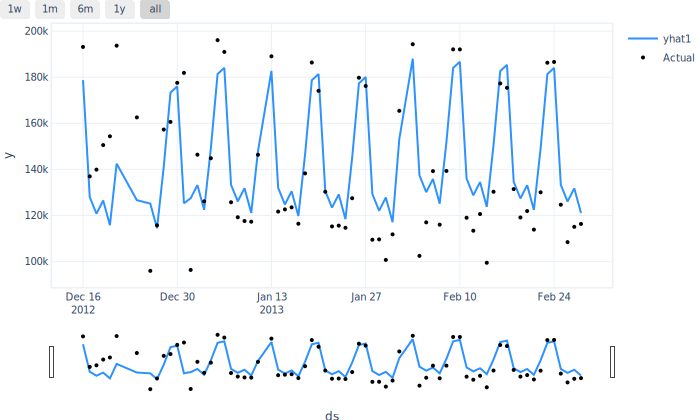

MAPE: 9.7%


In [16]:
params = {"weekly_seasonality":True}

m = NeuralProphet(**params)
m.add_future_regressor('day_of_month')
m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(train, freq='D')

forecast = m.predict(test)

m.plot(forecast)
print(f"MAPE: {mape(forecast['y'], forecast['yhat1'])}%")